# Path Labelling using Annotations from ASAP on Tiff files
In this notebook, we will demonstrate how to load annotaions from an ASAP XML file and visualise them on top of a whole slide image stored as a tiff.

In [1]:
from repath.utils.paths import project_root

camelyon16_dir = project_root() / 'data' / 'camelyon16'
annotations_path = camelyon16_dir / 'raw' / 'lesion_annotations' / 'tumor_078.xml'

## 1. Loading the annotations and slide
To load the annotation in from the disk we import the load_annotations function from the module corresponding to the format that we want to load. In this case, we load it from the `repath.data.annotation.asapxml`.

In [2]:
from repath.data.annotations.asapxml import load_annotations

annotations = load_annotations(annotations_path)
len(annotations)

96

Next, we need to load the slide and find out it's dimensions at the magnification level that we want to render the annotations at.

Just a quick note about levels. The convention for our API is that level 0 is the highest magnification in the WSI pyramid. This normally corresponds to 40x magnification at level 0 with the each level above that reducing the magnification by a half. So level 1 is 20x, level 2 is 10x, etc.

Classes that implement the SlideImageABC abstract base class, have a property called `dimensions` that can be used to retrieve the size of the slide at a level. It's an array of Sizes 

/home/ubuntu/repath/data/camelyon16/raw/tumor/tumor_078.tif
Size(width=1472, height=1736)
(1736, 1472, 3)


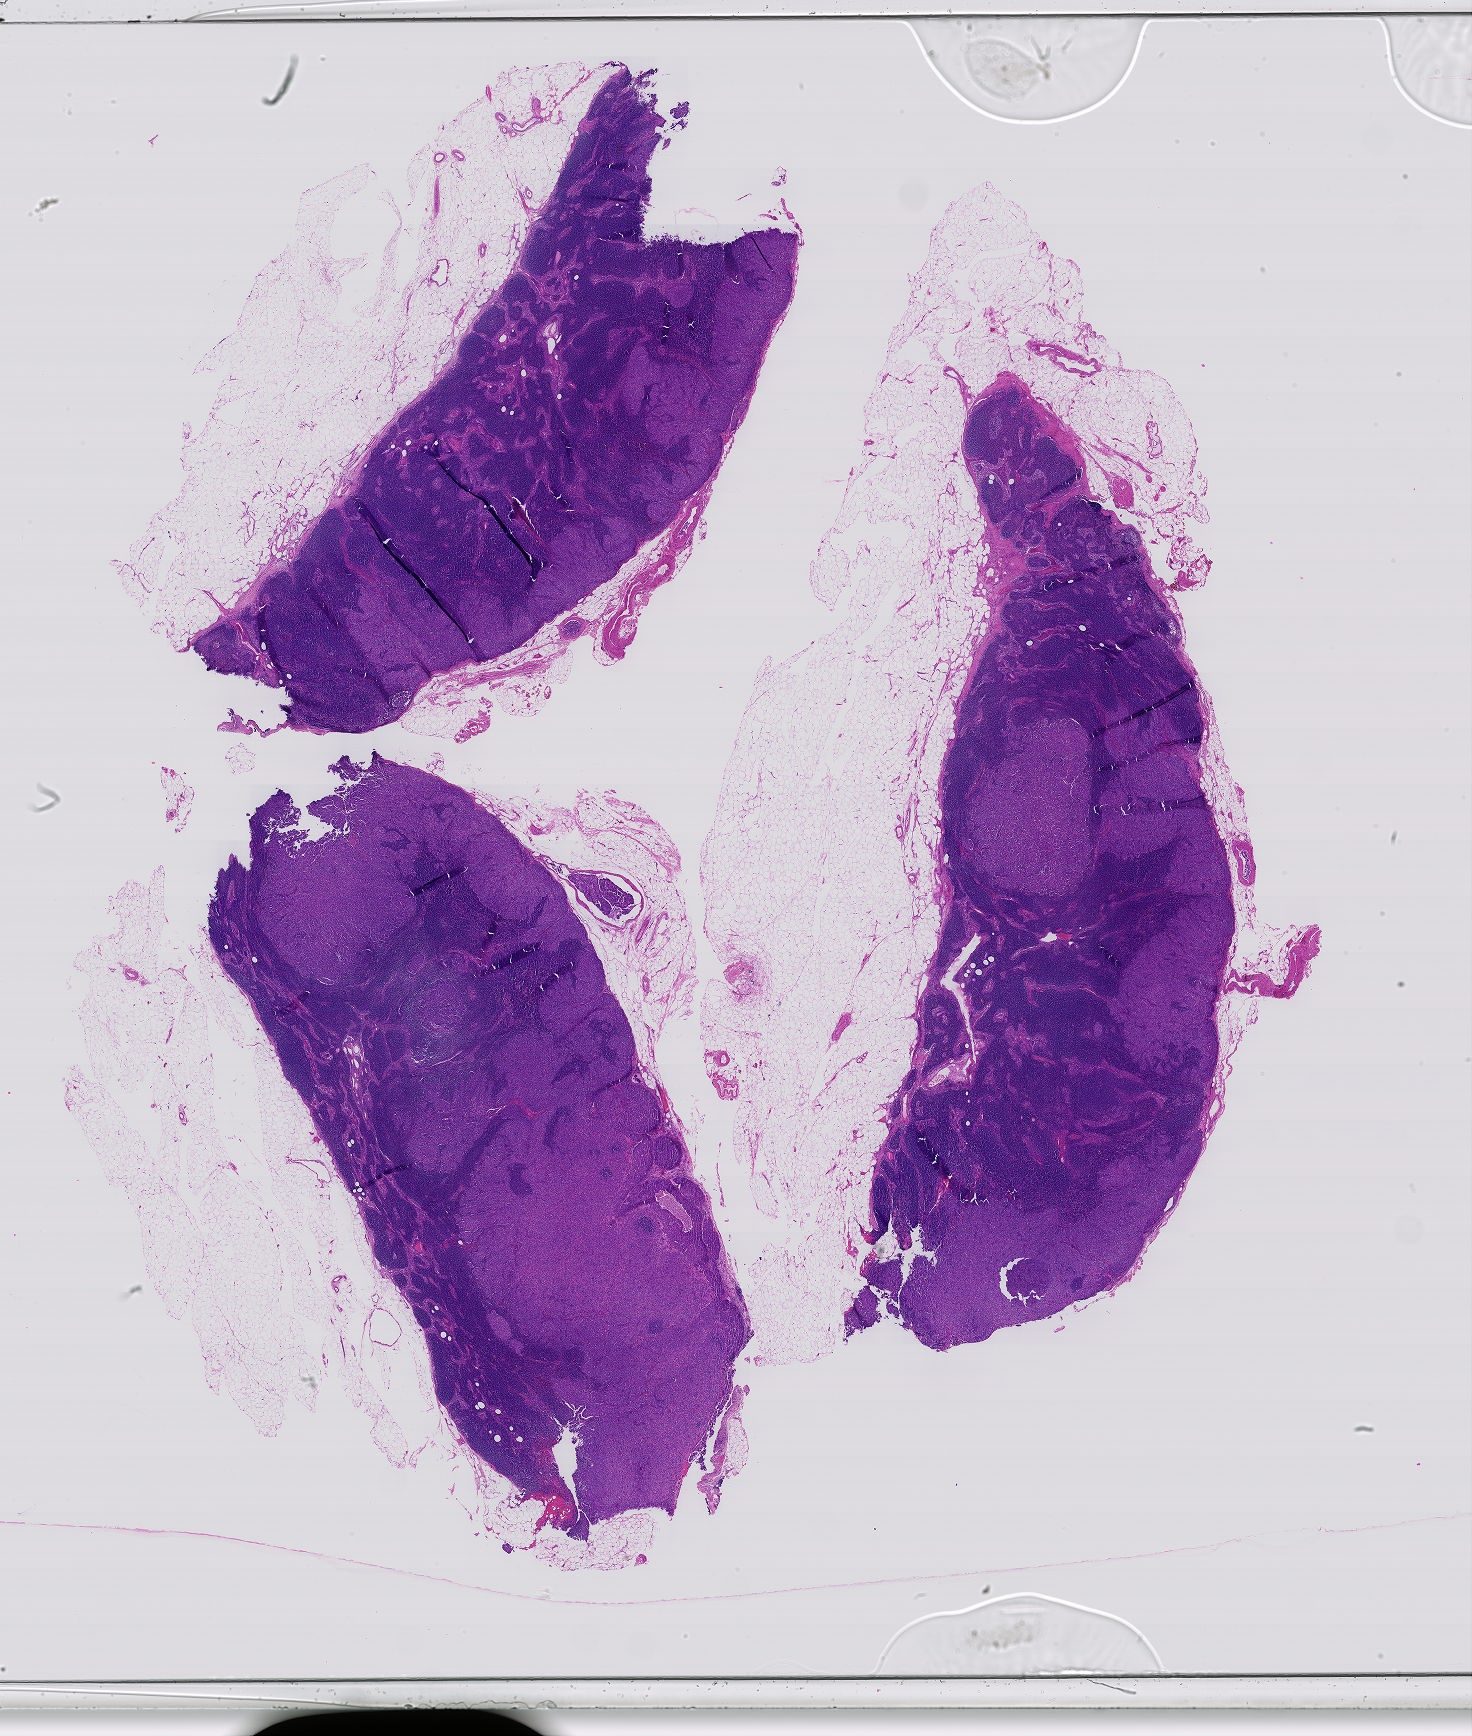

In [3]:
from repath.data.slides.openslide import Slide
from repath.utils.convert import np_to_pil

import numpy as np
import pandas as pd

slide_path = camelyon16_dir / 'raw' / 'tumor' / 'tumor_078.tif'

level = 6

with Slide(slide_path) as slide:
    print(slide.path)
    for image in slide.images:
        print(image.dimensions[level])
        thumb = image.get_thumbnail(level)
        print(thumb.shape)
        display(np_to_pil(thumb))
        



## 2. Tissue Identification
Next we are going to identify all the tissue in the slide by applying a simple background subtraction technique.

In [4]:
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu


def make_foreground_mask_wang(thumbnail: np.ndarray) -> np.ndarray:
    """creates a dataframe of pixels locations labelled as tissue or not

    Based on the method proposed by wang et all
    1. Convert from RGB to HSV
    2. Perform automatic thresholding using Otsu's method on the H and S channels
    3. Combine the thresholded H and S channels

    Args:
        thumbnail: A scaled down WSI image. Must be r,g,b.

    Returns:
        An ndarray of booleans with the same dimensions as the input image
        True means foreground, False means background
    """
    # convert the image into the hsv colour space
    image_hsv = rgb2hsv(thumbnail)

    # use Otsu's method to find the thresholds for hue and saturation
    thresh_h = threshold_otsu(image_hsv[:, :, 0])
    thresh_s = threshold_otsu(image_hsv[:, :, 1])

    # mask the image to get determine which pixels with hue and saturation above their thresholds
    mask_h = image_hsv[:, :, 1] > thresh_h
    mask_s = image_hsv[:, :, 1] > thresh_s

    # combine the masks with an OR so any pixel above either threshold counts as foreground
    np_mask = np.logical_or(mask_h, mask_s)
    return np_mask

## 3. Drawing the annotations
It's time to render the annotations! This creates a numpy array the same size as the WSI at a specified level with an integer value for the label.

The render_annotations function takes in the shape of the image to be created. This should be the same shape as the slide dimensions at that level, clipped to the nearest power of 2 downsampling of patch_level (or level 0) in order for the patch labelling not to suffer from aliasing artifacts when we downsample it from labels_level. It's a good idea not to use a level for the labels_level if it requires clipping.

The scale_factor parameter if a float specifying how to scale the annotation coordinates.

Labels is a dictionary specifying how to translate the string labels in the annotations into integers in the returned annotations image.

No handles with labels found to put in legend.
[False  True]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0
2
[0 1 2]
(1736, 1472)


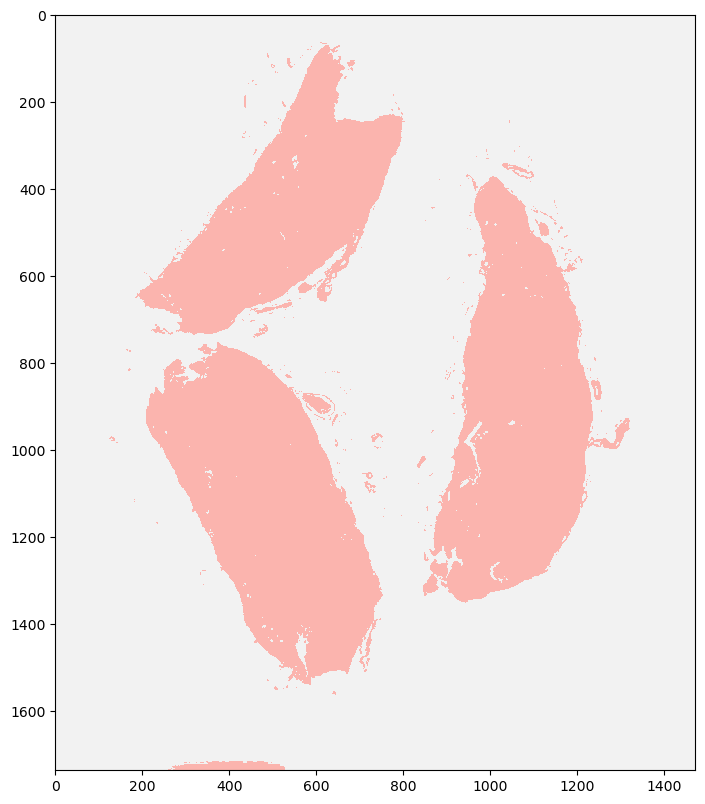

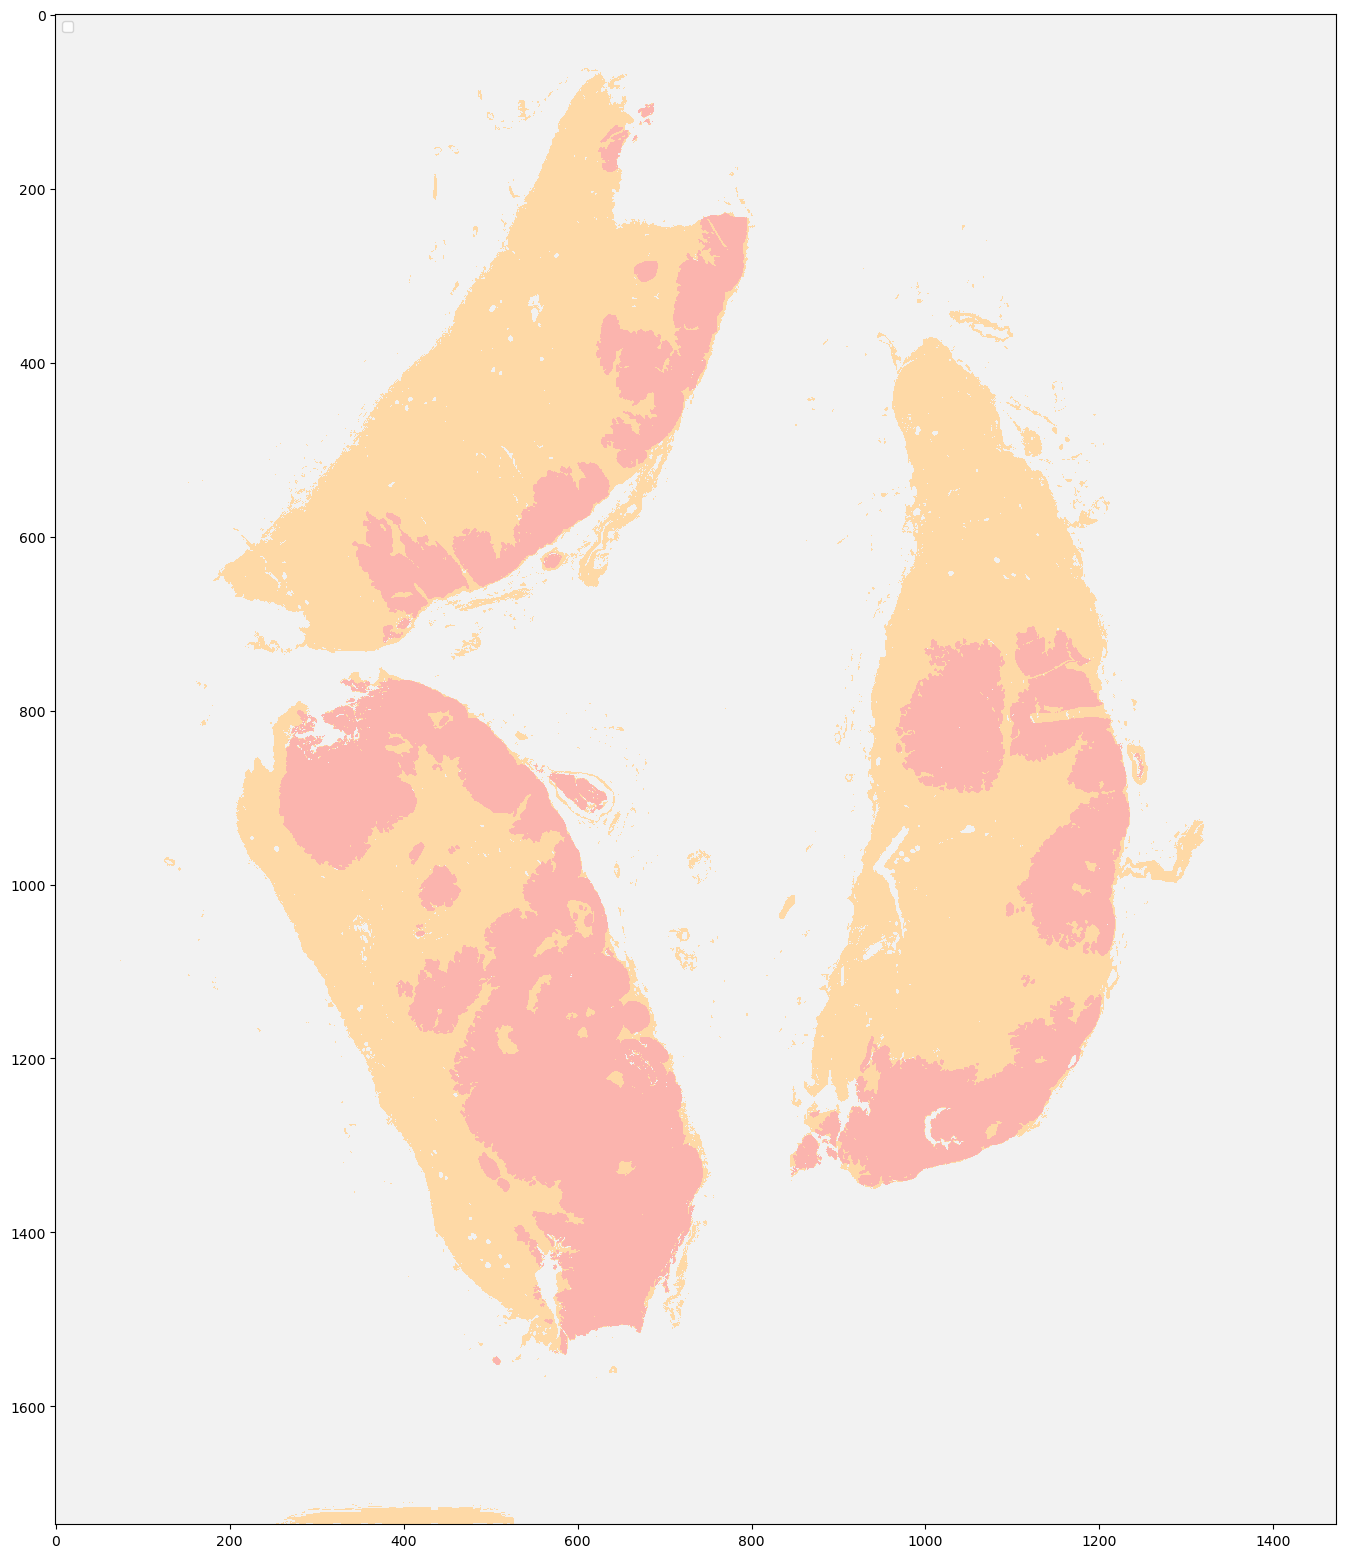

In [5]:
%matplotlib inline
from matplotlib.pyplot import imshow, figure, legend
from matplotlib import cm

from repath.data.annotations.annotation import render_annotations

level = 6
labels = {'background': 0, 'normal': 1, 'tumor': 2}
labels_order = ['background', 'tumor', 'normal']  # draw normal annotations ontop of tumor to 'cut out'

with Slide(slide_path) as slide:
    for image in slide.images:
        thumb = image.get_thumbnail(level)
        scale_factor = 2 ** level
        annotations_img = render_annotations(annotations, scale_factor, thumb.shape[:-1], labels, labels_order, 'normal')
        
        # apply the tissue mask based on the thumbnail
        tissue_mask = make_foreground_mask_wang(thumb)
        figure(figsize=(10, 10), dpi=100)
        tissue_cmap = cm.get_cmap('Pastel1', 2).reversed()
        imshow(tissue_mask, cmap=tissue_cmap)
        print(np.unique(tissue_mask))
        print(tissue_mask)

        annotations_img[~tissue_mask] = 0

        print(np.min(annotations_img))
        print(np.max(annotations_img))
        print(np.unique(annotations_img))
        print(annotations_img.shape)

        # draw the labels image ontop of the slide thumbnail
        figure(figsize=(20,20), dpi=100)
        labels_cmap = cm.get_cmap('Pastel1', 3).reversed()
        # imshow(np_to_pil(thumb))
        legend(loc="upper left")
        imshow(annotations_img, cmap=labels_cmap) # Red regions contains cancer.

## 4. Patching the slide up using the annotations
The next step is to use the rendered annotations (stored in label_image) to generate an index of all the labels for each patch in the image.

Scale factor:	64
kernel_size:	4
Found:		(434, 368) patches.
(434, 368)
[0 1 2]
Expected:	(434, 368) patches.
Slide image size at level 0: Size(width=94208, height=111104).
Slide image size at level 6: Size(width=1472, height=1736).
Patch shape x patch size: (94208, 111104)


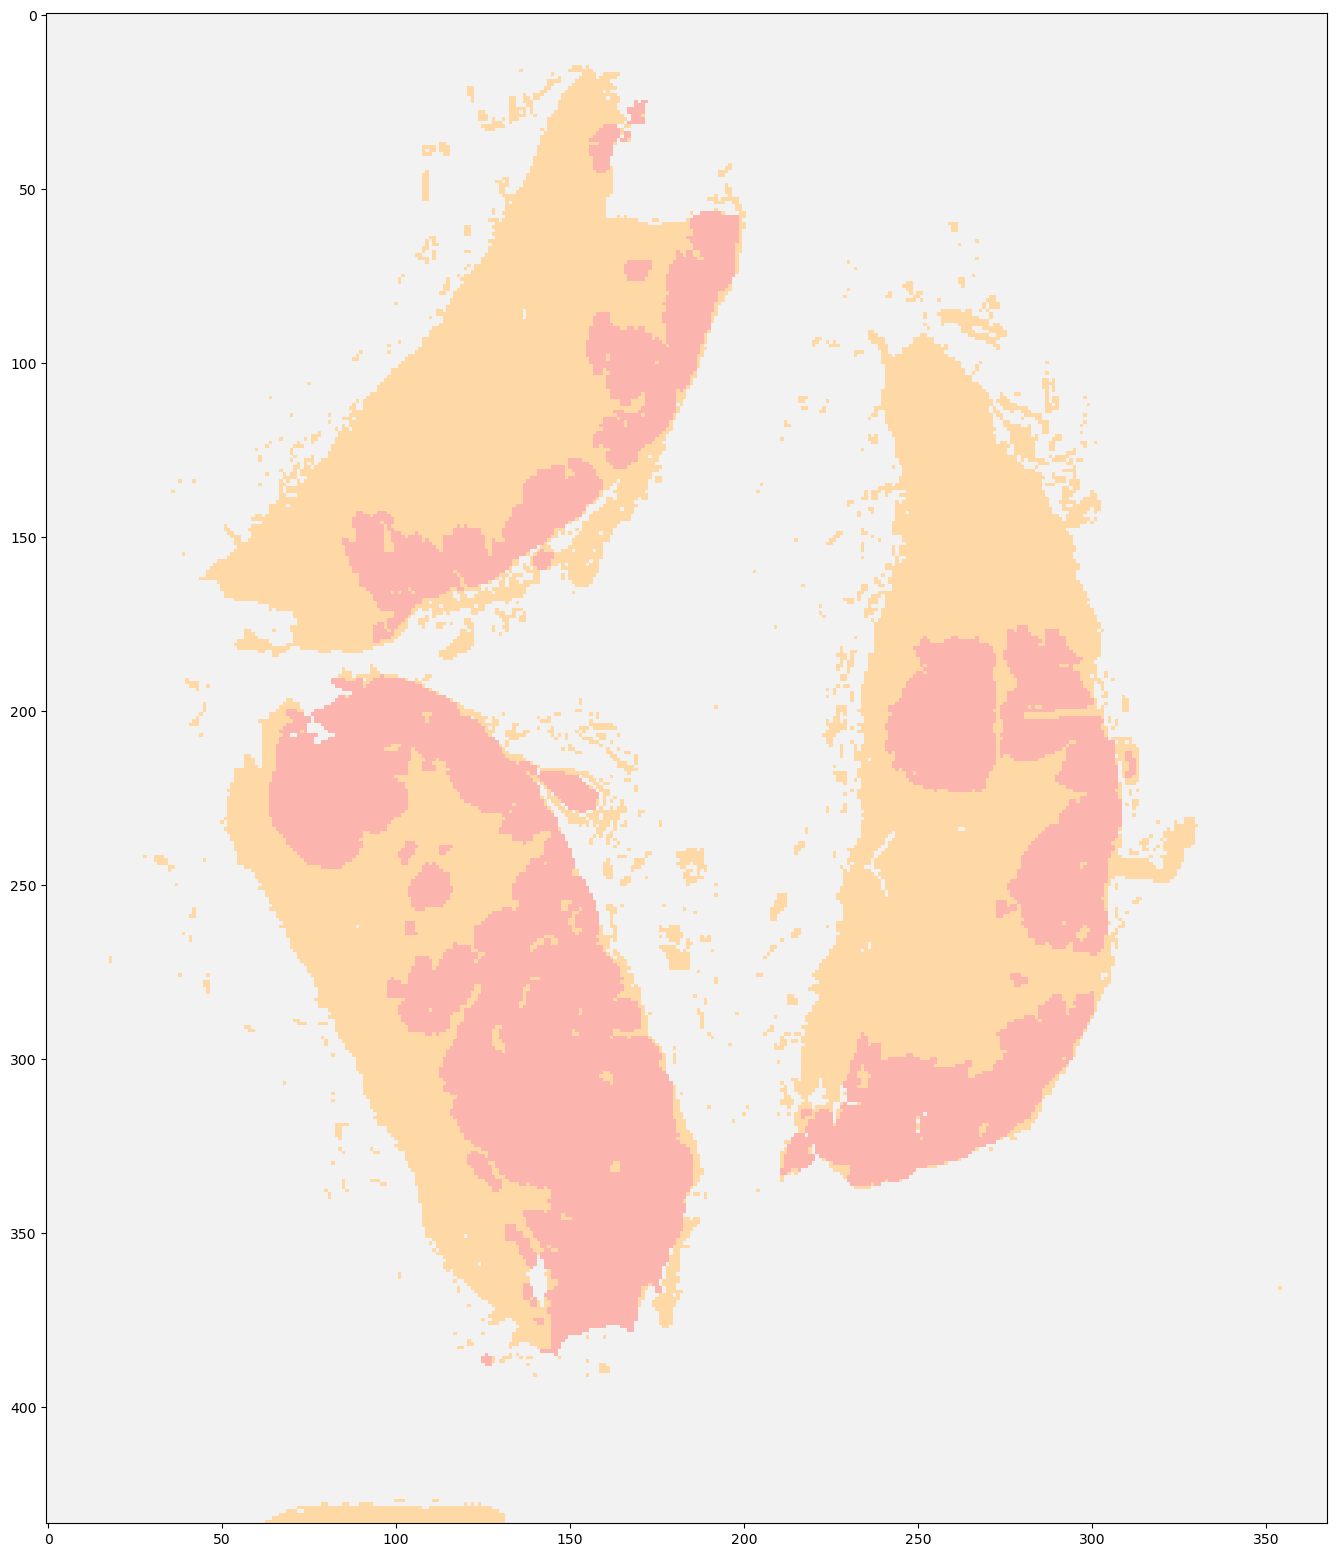

In [6]:
from repath.utils.convert import to_frame_with_locations
from repath.utils.filters import pool2d

# parameters for patching via a grid
patch_level = 0
labels_level = 6
patch_size = 256

# compute the kernel size
scale_factor = 2 ** (labels_level - patch_level)
kernel_size = int(patch_size / scale_factor)

print(f"Scale factor:\t{scale_factor}")
print(f"kernel_size:\t{kernel_size}")

# downsample using max pooling to get the patch labels
patch_labels = pool2d(annotations_img, kernel_size, kernel_size, 0)
print(f"Found:\t\t{patch_labels.shape} patches.")

# show the patch_lables
figure(figsize=(20,20), dpi=100)
print(patch_labels.shape)
labels_cmap = cm.get_cmap('Pastel1', 3).reversed()
print(np.unique(patch_labels))
imshow(patch_labels, cmap=labels_cmap)

# check that this downscaling operation is consistant with the number of patches we were expecting
with Slide(slide_path) as slide:
    for image in slide.images:
        zero_size = image.dimensions[0]
        print(f"Expected:\t{int(zero_size.height / patch_size), int(zero_size.width / patch_size)} patches.")
        print(f"Slide image size at level 0: {zero_size}.")
        six_size = image.dimensions[6]
        print(f"Slide image size at level 6: {six_size}.")
        print(f"Patch shape x patch size: {patch_labels.shape[1] * patch_size, patch_labels.shape[0] * patch_size}")



In [7]:
df = to_frame_with_locations(patch_labels, "label")
print(df.label.unique())
df

[0 1 2]


row  column  label
0         0       0      0
1         0       1      0
2         0       2      0
3         0       3      0
4         0       4      0
...     ...     ...    ...
159707  433     363      0
159708  433     364      0
159709  433     365      0
159710  433     366      0
159711  433     367      0

[159712 rows x 3 columns]

In [8]:
df.row *= patch_size
df.column *= patch_size
df = df.rename(columns={"row": "y", "column": "x"})
df = df.reindex(columns=['x', 'y', 'label'])
df

x       y  label
0           0       0      0
1         256       0      0
2         512       0      0
3         768       0      0
4        1024       0      0
...       ...     ...    ...
159707  92928  110848      0
159708  93184  110848      0
159709  93440  110848      0
159710  93696  110848      0
159711  93952  110848      0

[159712 rows x 3 columns]

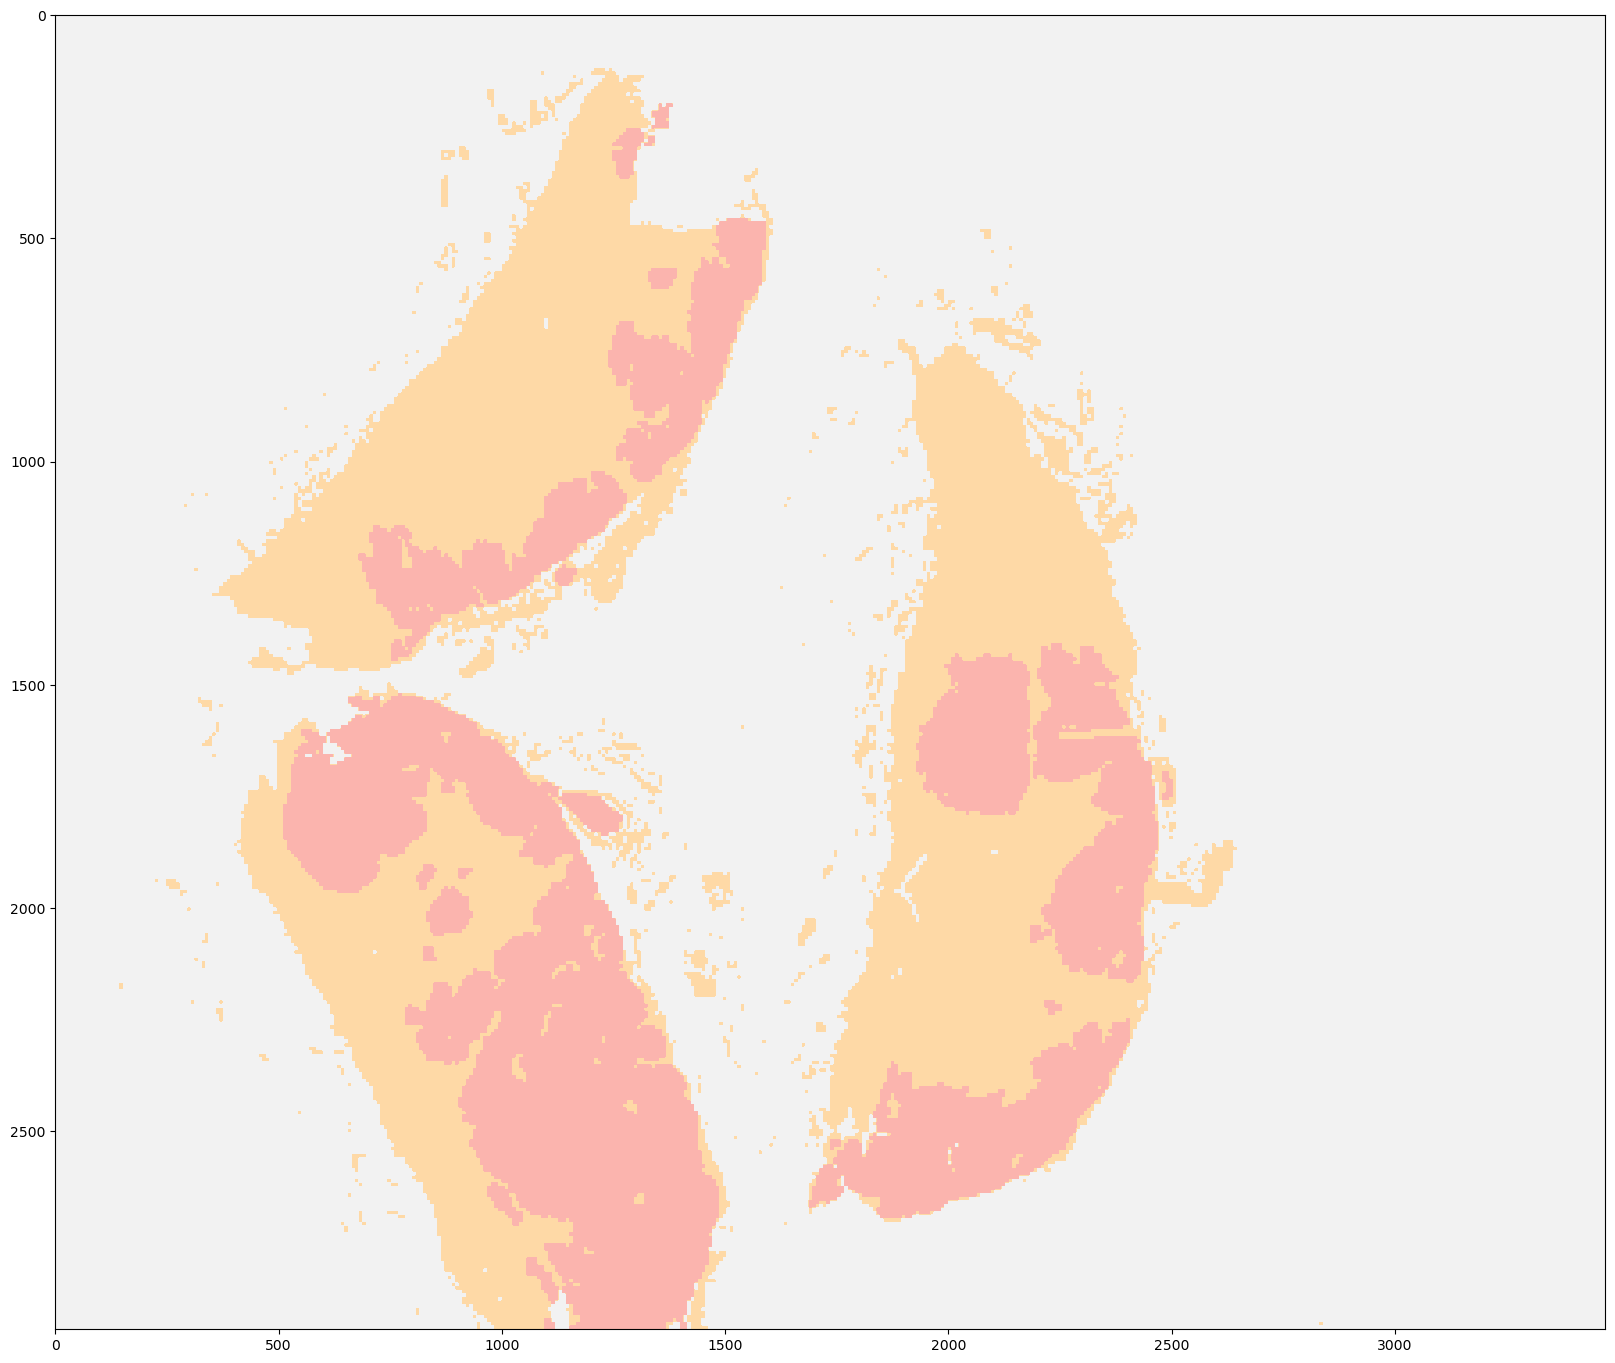

In [13]:
import cv2

from repath.utils.geometry import Shape

def draw_patches(patches_df: pd.DataFrame, shape: Shape, patch_size: int, factor: float, background_idx: int) -> np.array:
    image = np.full(shape, background_idx, dtype='float')
    size = patch_size * factor
    for p in patches_df.itertuples(index=False):
        start = (int(p.x * factor), int(p.y * factor))
        end = (int(p.x * factor + size), int(p.y * factor + size))
        cv2.rectangle(image, start, end, p.label, -1)
    return image.astype('int')

# let's render the patches at level 5 as a test. 
# They should be at level 0, which means the scale factor:
# scale_factor = 1 / (2 ** (target_level - patches_level))
view_level = 5
scale_factor = 1 / (2 ** view_level)

# get the image shape at level 5
with Slide(slide_path) as slide:
    for image in slide.images:
        image_shape = image.dimensions[view_level]

# then let's draw the patches
patches_image = draw_patches(df, image_shape, 256, scale_factor, 0)
np.unique(patches_image)

# draw the patches image
figure(figsize=(20,20), dpi=100)
labels_cmap = cm.get_cmap('Pastel1', 3).reversed()
imshow(patches_image, cmap=labels_cmap) 

In [16]:
# randomly jitter the x and y values

from random import randint

jitter_amount = 16

def jitter(val: int) -> int:
    val = val - randint(0, jitter_amount)
    return val if val > 0 else 0

df["x"] = df["x"].apply(jitter)
df["y"] = df["y"].apply(jitter)